
WPC Frontal Data
=========

Plots Fronts from WPC text files.
https://thredds-test.unidata.ucar.edu/thredds/catalog/noaaport/text/fronts/catalog.html

* Data kept on server for approx. 1 month


#### Imports

In [1]:
import pandas as pd

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import patheffects

from metpy.plots import add_metpy_logo, current_weather, sky_cover, StationPlot

In [3]:
extent=[-130, -65, 20, 65]
def create_map(extent=extent):
    # Set up the map projection
    proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=35,
                             standard_parallels=[35])

    # Change the DPI of the resulting figure. Higher DPI drastically improves the
    # look of the text rendering.
    plt.rcParams['savefig.dpi'] = 255
    # Set the font 
    
    # Create the figure and an axes set to the projection.
    fig = plt.figure(figsize=(20, 10))
    add_metpy_logo(fig, 1100, 300, size='large')
    ax = fig.add_subplot(1, 1, 1, projection=proj)

    # Add some various map elements to the plot to make it recognizable.
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.LAKES)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.STATES)
    ax.add_feature(cfeature.BORDERS)

    # Set plot bounds
    ax.set_extent(extent)
    return fig,ax

#### Code to Parse Lat/Lon Frontal/METAR data

In [4]:
def front_parse_latlon(latlon_code="0560149",print_on=True):
    '''Grab lat and lon from coded values from WPC frontal analysis data
    
    Arguments
    ---------
    code : string
        ***** required - 7 digit string *****
        * format in XXXYYYY, with:
        XXX : 3-digit latitude; with a period in front of last digit
            ex. 384 -> 38.4 -> 38.4 deg north
            ex. 045 -> 04.5 -> 4.5 deg north
            ex. 009 -> 00.9 -> 0.9 deg north
        YYYY : 4-digit longitude; with a period in front of last digit
            ex. 1147 -> 114.7 -> 114.7 deg west
            ex. 0979 -> 097.9 -> 97.9 deg west
            ex. 0035 -> 003.5 -> 3.5 deg west
            
    Returns
    -------
    lat : str
        converted latitude
    lon : str
        converted longitude
    '''
    if len(latlon_code) != 7:
        raise Exception(f"Wrong number of digits in coded lat/lon: {latlon_code}\n\n"+\
                        f"Coded lat/lon number of digits: {len(latlon_code)}\n"+\
                        
                       "\nPlease check data and ensure you are given coded lat/lon pairs with 7 digits.\n"+\
                    "\nsee docs\n")
    lat_raw = latlon_code[0:3]
    lon_raw = latlon_code[3:]
    if print_on == True:
        print("-----------------------------------------------------")
        print(f"raw latitude: {lat_raw}\nraw longitude: {lon_raw}\n")
    
    lat = f"{latlon_code[0:2]}.{latlon_code[2:3]}".strip("00")
    lon = f"{latlon_code[3:-1]}.{latlon_code[-1:]}".strip("00")
    if print_on == True:
        print(f"converted latitude (N): {float(lat)}\nconverted longitude (W): {float(lon)}\n")
    
    return lat,lon

In [109]:
front_parse_latlon(latlon_code="065049",print_on=True)

Exception: Wrong number of digits in coded lat/lon: 065049

Coded lat/lon number of digits: 6

Please check data and ensure you are given coded lat/lon pairs with 7 digits.

see docs


#### Parse lat/lons for fronts and/or max/min

In [5]:
def get_front_lat_lon(fronts_data,index):
    
    fronts_data = fronts_data.iloc[index][0].split()
    
    fronts = [front_parse_latlon(i,print_on=False) for i in fronts_data[1:]]
    
    lats_fronts = [float(i[0]) for i in fronts]
    # make the longitudes negative since they are in degrees west
    lons_fronts = [-float(i[1]) for i in fronts]
    return lats_fronts,lons_fronts

#### Get the indicies for each of the different front types

In [58]:
def get_front_indices(fronts_data,front):
    index = []
    #print("getting the indicies...\n")
    for i in range(fronts_data.shape[0]):
        if fronts_data.iloc[i][0][0:len(front)] == front:
            #print(i," ",fronts_data.iloc[i][0][0:4])
            index.append(i)
            
    # Shorter code, but not as readable       
    #[i for i in range(fronts_data.shape[0]) if fronts_data.iloc[i][0][0:len(front)] == front]
    
    return index

---

## Read in the WPC frontal analysis from text file

In [90]:
fronts_data = pd.read_fwf("data/Fronts_highres_KWBC_20201025_0000.txt",
                          header=None)

In [7]:
# quick look at data
fronts_data.head(20)

,0
0,
1,908
2,ASUS02 KWBC 250000
3,CODSUS
4,CODED SURFACE FRONTAL POSITIONS
5,NWS WEATHER PREDICTION CENTER COLLEGE PARK MD
6,931 PM EDT SAT OCT 24 2020
7,VALID 102500Z
8,HIGHS 1015 2050968 1025 4700809 1013 3711075 1...
9,5611264 1042 5501185 1042 5051136 1017 3340689


---

In [8]:
fronts_data.shape[0]

150

In [20]:
#lats_warm,lons_warm
def add_latlon_to_df(df,lats,lons,front):
    """Add existing set of lat/lon pairs from specific front (Hi/Lo) 
    to the already created pandas dataframe
    
    Parameters
    ----------
    df : pandas.core.frame.DataFrame
        existing dataframe to add new rows
        
    lats : list
        latitudes (must match dimensions of lons)
    
    lons : list
        longitudes (must match dimensions of lats)   
    
    Returns
    -------
    df : pandas.core.frame.DataFrame
        updated dataframe
    """
    for i in range(len(lats)):
        to_append = [front,lats[i],lons[i]]
        to_series = pd.Series(to_append, index = df.columns)
        df = df.append(to_series, ignore_index=True)
    return df

In [96]:
df = pd.DataFrame({'name': "name",
                           'latitude': [0],
                           'longitude': [0],
                      },index=None)

In [97]:
df

,name,latitude,longitude
0,name,0,0


## Cold Fronts

#### Search through earch row to see if the first four characters are "COLD"
* place them in a list
    * for now, will probably be added to pandas dataframe instead eventually

In [92]:
cold_index = get_front_indices(fronts_data,front="COLD")
cold_index

[20, 32, 33, 35, 38, 54, 60, 96, 108, 109, 111, 114, 122]

In [98]:
for i in cold_index:    
    lats_cold,lons_cold = get_front_lat_lon(fronts_data,i)
    df = add_latlon_to_df(df,lats_cold,lons_cold,front="COLD")

#### Create dataframe and add COLD as our first entries with lats and lons

In [86]:
df

,name,latitude,longitude
0,COLD,73.2,-141.5
1,COLD,71.9,-150.7
2,COLD,71.2,-156.3
3,COLD,70.0,-164.2
4,COLD,69.3,-169.6
5,COLD,68.8,-174.3


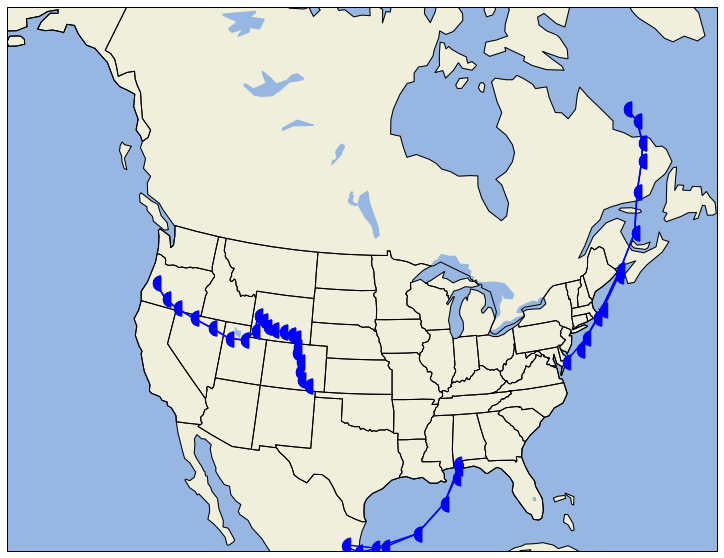

In [80]:
fig,ax = create_map()
t = mpl.markers.MarkerStyle(marker='$\u25D6$')
for i in cold_index:  
    lats_cold,lons_cold = get_front_lat_lon(fronts_data,i)
    plt.plot(lons_cold, lats_cold, marker='$\u25D6$',ms=15,color='blue', 
         transform=ccrs.PlateCarree())
plt.show()

## Warm Fronts

In [81]:
warm_index = get_front_indices(fronts_data,front="WARM")

In [87]:
for i in warm_index:    
    lats_warm,lons_warm = get_front_lat_lon(fronts_data,i)
    df = add_latlon_to_df(df,lats_warm,lons_warm,front="WARM")

In [83]:
df = add_latlon_to_df(df,lats_warm,lons_warm,front="WARM")

In [88]:
df

,name,latitude,longitude
0,COLD,73.2,-141.5
1,COLD,71.9,-150.7
2,COLD,71.2,-156.3
3,COLD,70.0,-164.2
4,COLD,69.3,-169.6
5,COLD,68.8,-174.3
6,WARM,57.5,-58.9
7,WARM,57.1,-55.9
8,WARM,55.8,-52.5
9,WARM,54.5,-50.3


In [30]:
import matplotlib as mpl

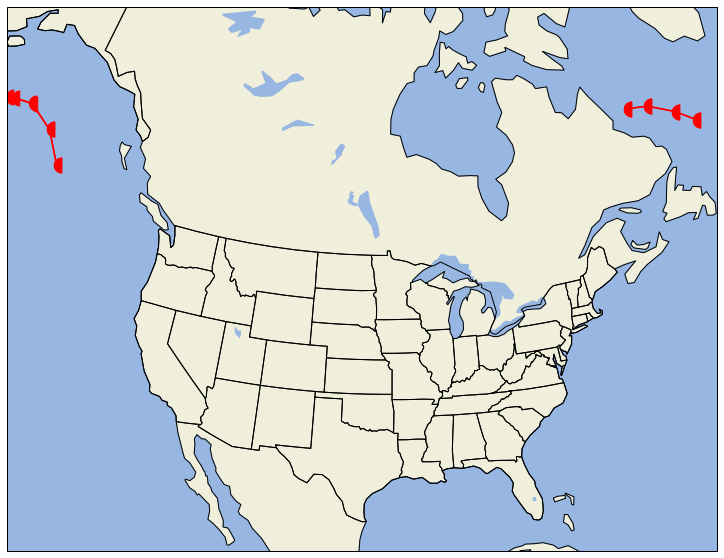

In [101]:
fig,ax = create_map()
t = mpl.markers.MarkerStyle(marker='$\u25D6$')
for i in warm_index:  
    lats_warm,lons_warm = get_front_lat_lon(fronts_data,i)
    plt.plot(lons_warm, lats_warm, marker='$\u25D6$',ms=15,color='red', 
         transform=ccrs.PlateCarree())
plt.show()

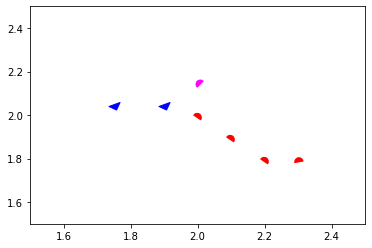

In [33]:

# - - - - - - - - - Fake Fronts - - - - - - - - - 

t = mpl.markers.MarkerStyle(marker='$\u25D6$')
#t = '$\u25D6$'
angle = 100+180
t._transform = t.get_transform().rotate_deg(angle)
plt.scatter(2.3, 1.8, marker = t, s=70, linestyle='None',color="r")

t = mpl.markers.MarkerStyle(marker='$\u25D6$')
#t = '$\u25D6$'
angle = 56+180
t._transform = t.get_transform().rotate_deg(angle)

plt.scatter(2, 2, marker = t, s=70, linestyle='None',color="r")
plt.scatter(2.1, 1.9, marker = t, s=70, linestyle='None',color="r")
plt.scatter(2.2, 1.8, marker = t, s=70, linestyle='None',color="r")

# - - - - - - - - - Occluded Front - - - - - - - - - 

t = mpl.markers.MarkerStyle(marker='$\u25D6$')
#t = '$\u25D6$'
angle = 360-45
t._transform = t.get_transform().rotate_deg(angle)

plt.scatter(2., 2.15, marker = t, s=70, linestyle='None',color="magenta")
#plt.scatter(2.1, 1.9, marker = t, s=70, linestyle='None',color="magenta")
#plt.scatter(2.2, 1.8, marker = t, s=70, linestyle='None',color="magenta")

# - - - - - - - - - Cold Front - - - - - - - - - 

t = mpl.markers.MarkerStyle(marker='$\u25E3$')
#t = '$\u25D6$'
angle = 245-180
t._transform = t.get_transform().rotate_deg(angle)
plt.scatter(1.9, 2.05, marker = t, s=70, linestyle='None',color="b")
plt.scatter(1.75, 2.05, marker = t, s=70, linestyle='None',color="b")


plt.xlim([1.5,2.5])
plt.ylim([1.5,2.5])

#plt.show()
plt.savefig("output/not_quite_fronts.png",bbox_inches="tight")

---

#### Plot the Highs, Lows, Cold and Warm Fronts

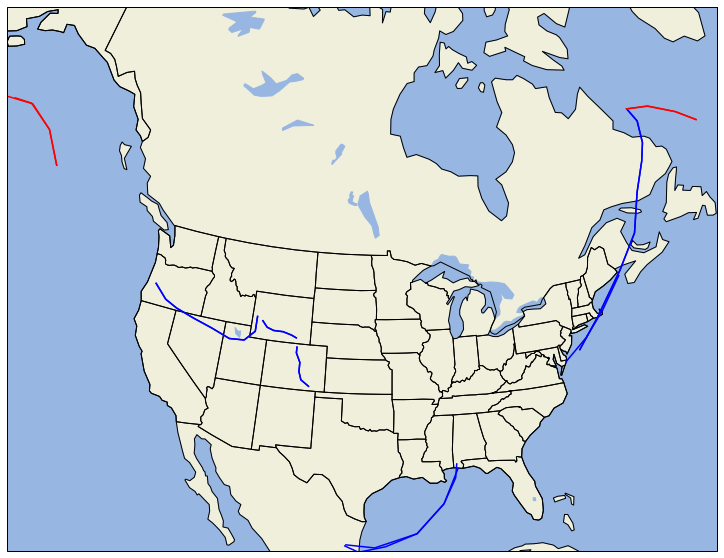

In [102]:
fig,ax = create_map()

for i in cold_index:  
    lats_cold,lons_cold = get_front_lat_lon(fronts_data,i)
    plt.plot(lons_cold, lats_cold, color='blue', 
         transform=ccrs.PlateCarree())
for i in warm_index:  
    lats_warm,lons_warm = get_front_lat_lon(fronts_data,i)
    plt.plot(lons_warm, lats_warm, color='red', 
         transform=ccrs.PlateCarree())
plt.show()

---

## Stationary Fronts

In [103]:
stnry_index = get_front_indices(fronts_data,front="STNRY")
stnry_index

for i in stnry_index:    
    lats_stnry,lons_stnry = get_front_lat_lon(fronts_data,i)
    df = add_latlon_to_df(df,lats_stnry,lons_stnry,front="STNRY")

#### Plot the Highs, Lows, Cold, Warm, and Stationary Fronts

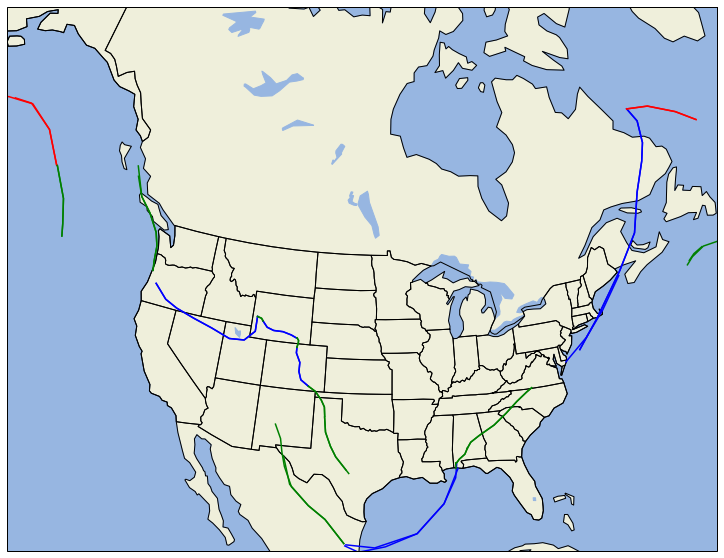

In [104]:
fig,ax = create_map()

for i in cold_index:  
    lats_cold,lons_cold = get_front_lat_lon(fronts_data,i)
    plt.plot(lons_cold, lats_cold, color='blue', 
         transform=ccrs.PlateCarree())
for i in warm_index:  
    lats_warm,lons_warm = get_front_lat_lon(fronts_data,i)
    plt.plot(lons_warm, lats_warm, color='red', 
         transform=ccrs.PlateCarree())
for i in stnry_index:  
    lats_stnry,lons_stnry = get_front_lat_lon(fronts_data,i)
    plt.plot(lons_stnry, lats_stnry, color='green', 
         transform=ccrs.PlateCarree())
plt.show()

---

## Occluded Fronts

In [105]:
ocfnt_index = get_front_indices(fronts_data,front="OCFNT")
ocfnt_index

for i in ocfnt_index:    
    lats_ocfnt,lons_ocfnt = get_front_lat_lon(fronts_data,i)
    df = add_latlon_to_df(df,lats_ocfnt,lons_ocfnt,front="OCFNT")

#### Plot the Highs, Lows, Cold, Warm, Stationary, and Occluded Fronts

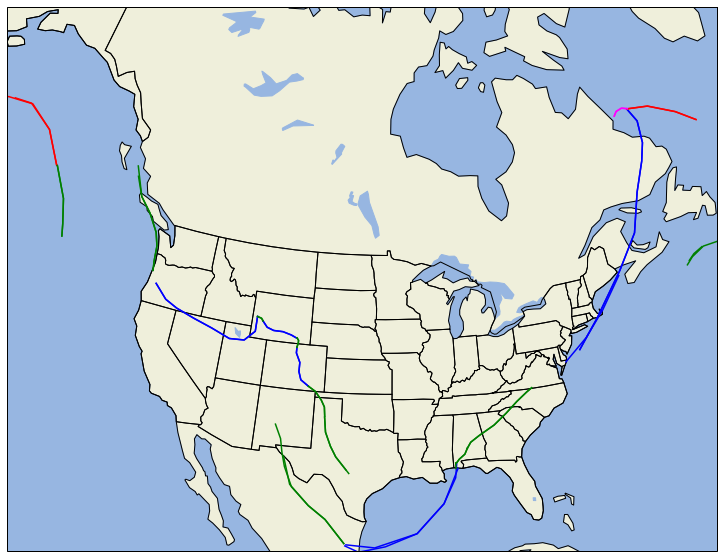

In [107]:
fig,ax = create_map()

for i in cold_index:  
    lats_cold,lons_cold = get_front_lat_lon(fronts_data,i)
    plt.plot(lons_cold, lats_cold, color='blue', 
         transform=ccrs.PlateCarree())
for i in warm_index:  
    lats_warm,lons_warm = get_front_lat_lon(fronts_data,i)
    plt.plot(lons_warm, lats_warm, color='red', 
         transform=ccrs.PlateCarree())
for i in stnry_index:  
    lats_stnry,lons_stnry = get_front_lat_lon(fronts_data,i)
    plt.plot(lons_stnry, lats_stnry, color='green', 
         transform=ccrs.PlateCarree())
for i in ocfnt_index:  
    lats_occ,lons_occ = get_front_lat_lon(fronts_data,i)
    plt.plot(lons_occ, lats_occ, color='magenta', 
         transform=ccrs.PlateCarree())
plt.show()

---

## TROFs

In [108]:
trof_index = get_front_indices(fronts_data,front="TROF")
trof_index

for i in trof_index:    
    lats_trof,lons_trof = get_front_lat_lon(fronts_data,i)
    df = add_latlon_to_df(df,lats_trof,lons_trof,front="TROF")

In [225]:
trof_index = [i for i in range(fronts_data.shape[0]) if fronts_data.iloc[i][0][0:4] == "TROF"]

#### Plot the Highs, Lows, Cold, Warm, Stationary, Occluded Fronts and Trofs

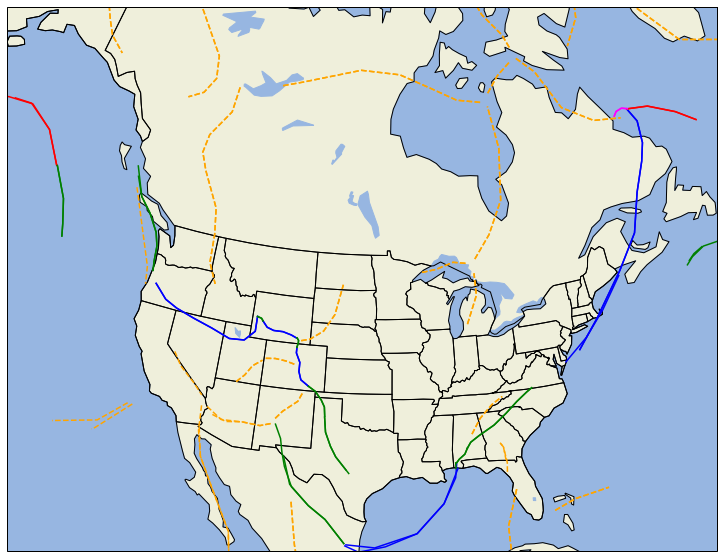

In [109]:
fig,ax = create_map()

for i in cold_index:  
    lats_cold,lons_cold = get_front_lat_lon(fronts_data,i)
    plt.plot(lons_cold, lats_cold, color='blue', 
         transform=ccrs.PlateCarree())
for i in warm_index:  
    lats_warm,lons_warm = get_front_lat_lon(fronts_data,i)
    plt.plot(lons_warm, lats_warm, color='red', 
         transform=ccrs.PlateCarree())
for i in stnry_index:  
    lats_stnry,lons_stnry = get_front_lat_lon(fronts_data,i)
    plt.plot(lons_stnry, lats_stnry, color='green', 
         transform=ccrs.PlateCarree())
for i in ocfnt_index:  
    lats_occ,lons_occ = get_front_lat_lon(fronts_data,i)
    plt.plot(lons_occ, lats_occ, color='magenta', 
         transform=ccrs.PlateCarree())
for i in trof_index:  
    lats_trof,lons_trof = get_front_lat_lon(fronts_data,i)
    plt.plot(lons_trof, lats_trof, color='orange',linestyle="--", 
         transform=ccrs.PlateCarree())
plt.show()

---

---